In [1]:
import bisect
import collections.abc
import os
import pickle
import pprint
from pathlib import Path
from typing import Dict, Iterable, List, Optional, TypedDict, TypeVar, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from jaxtyping import Float
from torch.utils.data import DataLoader, Dataset

from openretina.cell_type_training import (
    conv_core_frozen_readout,
    extract_chirp_mb,
    generate_cell_barcodes,
    metadata_model_full_objective,
    natmov_and_meta_dataloaders,
    transfer_readout_mask,
)
from openretina.hoefling_2024.configs import model_config
from openretina.hoefling_2024.data_io import (
    get_mb_dataloaders,
    natmov_dataloaders_v2,
)
from openretina.hoefling_2024.models import SFB3d_core_SxF3d_readout
from openretina.neuron_data_io import make_final_responses
from openretina.plotting import play_stimulus
from openretina.training import standard_early_stop_trainer as trainer
from openretina.utils.h5_handling import load_h5_into_dict
from openretina.utils.misc import CustomPrettyPrinter, tensors_to_device

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4, max_lines=40)

In [2]:
BASE_PATH = Path("/Data/fd_export/")

In [3]:
!ls $BASE_PATH | grep neuron_data

2024-01-11_neuron_data_stim_8c18928_responses_99c71a0.pkl
2024-01-11_neuron_data_stim_c285329_responses_0698360.pkl
2024-01-11_neuron_data_stim_c285329_responses_483c12d.pkl
2024-03-22_neuron_data_stim_c285329_responses_483c12d.h5
2024-03-25_neuron_data_responses_484c12d_djimaging.h5
2024-03-27_neuron_data_stim_c285329_responses_483c12d.h5
2024-03-28_neuron_data_responses_484c12d_djimaging.h5
2024-05-17_neuron_data_responses_484c12d_djimaging.h5
2024-06-20_neuron_data_responses_484c12d_djimaging.h5


In [4]:
data_path = os.path.join(BASE_PATH, "2024-06-20_neuron_data_responses_484c12d_djimaging.h5")
movies_path = os.path.join(BASE_PATH, "2024-01-11_movies_dict_c285329.pkl")
responses = load_h5_into_dict(data_path)
movies_dict = pickle.load(open(movies_path, "rb"))

Loading HDF5 file contents:   0%|          | 0/2077 [00:00<?, ?item/s]

In [5]:
movie_data_dict = make_final_responses(responses, response_type="natural", trace_type="spikes")

Upsampling natural spikes traces to get final responses.:   0%|          | 0/67 [00:00<?, ?it/s]

In [6]:
pp.pprint(movie_data_dict)

{   'session_1_ventral1_20200226': {   'chirp_preprocessed_traces': numpy.ndarray(shape=(131, 1501)),
                                       'chirp_qi': numpy.ndarray(shape=(131,)),
                                       'chirp_raw_traces': numpy.ndarray(shape=(131, 1501)),
                                       'chirp_smoothed_traces': numpy.ndarray(shape=(131, 1501)),
                                       'chirp_spike_times': numpy.ndarray(shape=(131, 1501)),
                                       'chirp_spikes': numpy.ndarray(shape=(131, 1501)),
                                       'chirp_traces_times': numpy.ndarray(shape=(131, 1501)),
                                       'chirp_trigger_times': numpy.ndarray(shape=(131, 10)),
                                       'd_qi': numpy.ndarray(shape=(131,)),
                                       'date': '2020-02-26',
                                       'ds_index': numpy.ndarray(shape=(131,)),
                                      

In [7]:
chirp_mb = extract_chirp_mb(movie_data_dict)

In [8]:
pp.pprint(chirp_mb)

{   'session_1_ventral1_20200226': {   'chirp': numpy.ndarray(shape=(131, 990)),
                                       'mb': numpy.ndarray(shape=(131, 984))},
    'session_1_ventral1_20200528': {   'chirp': numpy.ndarray(shape=(105, 990)),
                                       'mb': numpy.ndarray(shape=(105, 984))},
    'session_1_ventral1_20200707': {   'chirp': numpy.ndarray(shape=(171, 990)),
                                       'mb': numpy.ndarray(shape=(171, 984))},
    'session_1_ventral1_20201021': {   'chirp': numpy.ndarray(shape=(133, 990)),
                                       'mb': numpy.ndarray(shape=(133, 984))},
    'session_1_ventral1_20201030': {   'chirp': numpy.ndarray(shape=(105, 990)),
                                       'mb': numpy.ndarray(shape=(105, 984))},
    'session_1_ventral1_20210929': {   'chirp': numpy.ndarray(shape=(120, 990)),
                                       'mb': numpy.ndarray(shape=(120, 984))},
    'session_1_ventral1_20210930': {   '

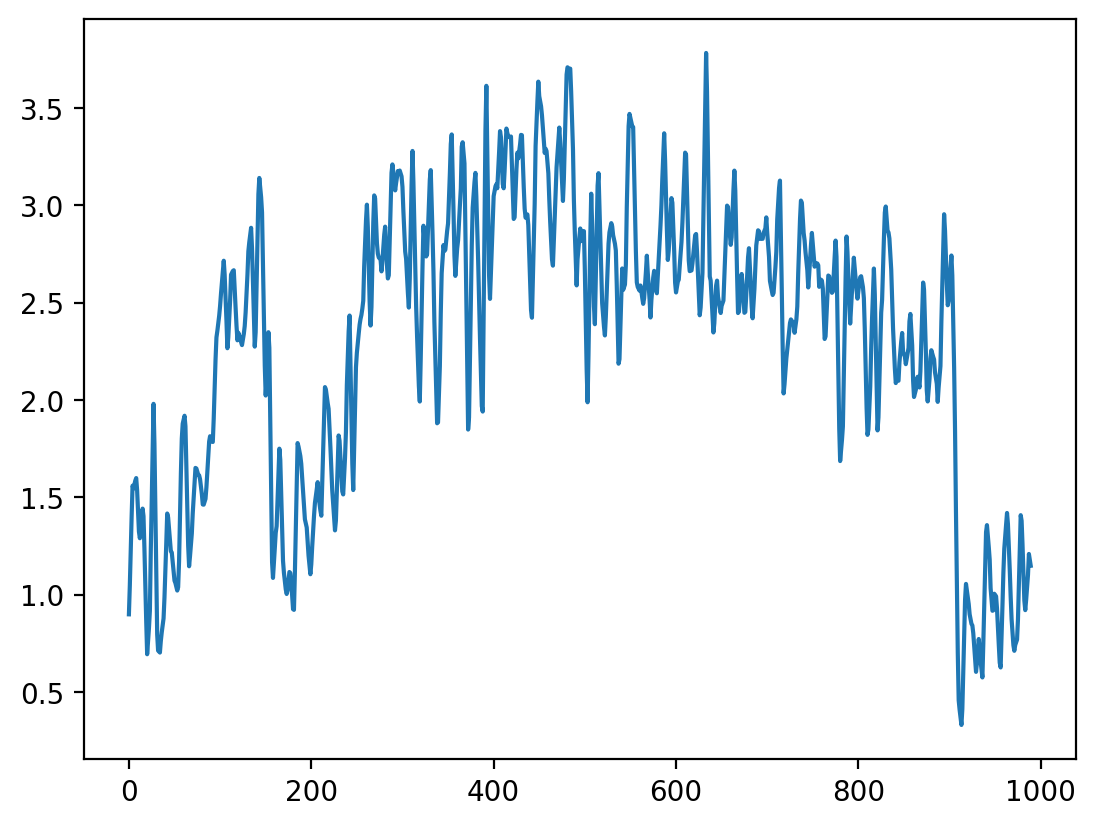

In [9]:
plt.plot(chirp_mb["session_1_ventral1_20200226"]["chirp"][8])

In [10]:
barcodes = generate_cell_barcodes(movie_data_dict, normalize=False, include_field_id=True)

In [11]:
pp.pprint(barcodes)

{   'session_1_ventral1_20200226': {   'cell_types': numpy.ndarray(shape=(131,)),
                                       'chirp_features': numpy.ndarray(shape=(131, 5)),
                                       'chirp_qi': numpy.ndarray(shape=(131, 1)),
                                       'd_qi': numpy.ndarray(shape=(131, 1)),
                                       'ds_index': numpy.ndarray(shape=(131, 1)),
                                       'field_id': numpy.ndarray(shape=(131,)),
                                       'os_index': numpy.ndarray(shape=(131, 1)),
                                       'pref_dir': numpy.ndarray(shape=(131, 1)),
                                       'roi_size_um2': numpy.ndarray(shape=(131, 1)),
                                       'temporal_nasal_pos_um': numpy.ndarray(shape=(131, 1)),
                                       'ventral_dorsal_pos_um': numpy.ndarray(shape=(131, 1))},
    'session_1_ventral1_20200528': {   'cell_types': numpy.ndarray(

In [12]:
means_dict = {}
std_dict = {}
for session in barcodes.keys():
    means_dict[session] = {}
    std_dict[session] = {}
    for field in barcodes[session]:
        if np.issubdtype(barcodes[session][field].dtype, np.number):
            means_dict[session][field] = np.mean(barcodes[session][field], axis=0)
            std_dict[session][field] = np.std(barcodes[session][field], axis=0)

In [13]:
np.random.seed(42)
normalising_means = {}
normalising_stds = {}
for session in means_dict.keys():
    if np.random.rand() > 0.5:
        continue
    for field in means_dict[session]:
        if normalising_means.get(field) is None:
            normalising_means[field] = []
            normalising_stds[field] = []
        normalising_means[field].append(np.atleast_2d(means_dict[session][field]))
        normalising_stds[field].append(np.atleast_2d(std_dict[session][field]))

In [14]:
pp.pprint(normalising_means)

{   'chirp_features': list(len=37),
    'chirp_qi': list(len=37),
    'd_qi': list(len=37),
    'ds_index': list(len=37),
    'os_index': list(len=37),
    'pref_dir': list(len=37),
    'roi_size_um2': list(len=37),
    'temporal_nasal_pos_um': list(len=37),
    'ventral_dorsal_pos_um': list(len=37)}


In [15]:
final_normalising_means = {}
final_normalising_stds = {}
for field in normalising_means.keys():
    final_normalising_means[field] = np.round(
        np.mean(np.concatenate(normalising_means[field], axis=0), axis=0), decimals=2
    )
    if "pos_um" not in field:
        final_normalising_stds[field] = np.round(
            np.mean(np.concatenate(normalising_stds[field], axis=0), axis=0), decimals=2
        )
    else:
        final_normalising_stds[field] = np.round(
            np.std(np.concatenate(normalising_means[field], axis=0), axis=0), decimals=2
        )

In [16]:
final_normalising_stds

{'chirp_features': array([0.03, 0.07, 0.72, 0.44, 2.52]),
 'roi_size_um2': array([40.74], dtype=float32),
 'chirp_qi': array([0.2], dtype=float32),
 'd_qi': array([0.15], dtype=float32),
 'ds_index': array([0.12], dtype=float32),
 'os_index': array([0.14], dtype=float32),
 'pref_dir': array([1.54], dtype=float32),
 'temporal_nasal_pos_um': array([623.39]),
 'ventral_dorsal_pos_um': array([392.18])}

In [17]:
final_normalising_means

{'chirp_features': array([0.19, 0.68, 2.27, 1.24, 7.38]),
 'roi_size_um2': array([81.13], dtype=float32),
 'chirp_qi': array([0.44], dtype=float32),
 'd_qi': array([0.75], dtype=float32),
 'ds_index': array([0.23], dtype=float32),
 'os_index': array([0.36], dtype=float32),
 'pref_dir': array([0.31], dtype=float32),
 'temporal_nasal_pos_um': array([271.27]),
 'ventral_dorsal_pos_um': array([-764.9])}

## Load moving bar model

In [18]:
mb_model_path = (
    "/Data/mb_model_factorised_17_06/models/SFB3d_core_SxF3d_readout_hoefling_2022_2024-06-17_model_weights.pt"
)
mb_weights = torch.load(mb_model_path)

In [19]:
mb_data_dict = make_final_responses(responses, response_type="mb", trace_type="spikes")
mb_dataloaders = get_mb_dataloaders(mb_data_dict)

Upsampling mb spikes traces to get final responses.:   0%|          | 0/67 [00:00<?, ?it/s]

Creating moving bars dataloaders:   0%|          | 0/67 [00:00<?, ?it/s]

In [20]:
model_config["gaussian_masks"] = False

In [21]:
mb_model = SFB3d_core_SxF3d_readout(**model_config, dataloaders=mb_dataloaders, seed=42)

Random seed 42 has been set.


In [22]:
mb_model.load_state_dict(mb_weights)

# For the way the gaussian readout is code in the current version, we need a forward pass for the masks to be computed,
# even if loading a model, as they are not directly a parameter but a class attribute.
with torch.no_grad():
    mb_model(torch.rand(1, 2, 50, 18, 16), list(mb_dataloaders["train"].keys())[0])

## Initialise cell type model

In [23]:
dataloaders = natmov_and_meta_dataloaders(
    movie_data_dict, movies_dict, batch_size=64, use_raw_traces=False, include_field_info=False
)

Creating movie dataloaders:   0%|          | 0/67 [00:00<?, ?it/s]

In [24]:
sample_loader = dataloaders["train"]

In [25]:
sample_loader["session_1_ventral1_20200226"].dataset.categorical_metadata

[array([17, 31, 40,  7, 11, 46,  1, 26, 22, 27, 31, 11, 22, 17, 27, 32,  7,
        11, 31, 12, 17, 32,  1, 17, 32, 43, 17, 11, 38, 10, 11, 17, 32, 32,
        32, 17, 17, 11, 11, 42, 32, 17, 17, 11, 43, 17, 17, 32, 32, 32, 11,
        32, 32, 17,  4, 17, 17, 12, 20, 32, 34,  8, 11,  4, 27, 32, 17, 32,
        17, 31, 38, 17, 32, 32, 17, 12, 27, 11, 17, 11, 13,  7, 17, 11, 43,
        42, 17, 17, 14, 11,  9, 43, 46, 32, 11, 32, 32, 32, 12, 17, 31, 23,
        32, 31, 32, 11, 12, 43,  1, 32, 32,  7, 17, 11, 32, 31, 12,  1, 12,
        27, 44, 14, 44, 32, 31, 43, 11, 11, 43, 27, 27])]

In [26]:
sample_batch = next(iter(sample_loader["session_1_ventral1_20200226"]))

In [27]:
sample_batch.numerical_metadata.shape

torch.Size([64, 131, 13])

In [28]:
ct_model_config = {
    "layers": 2,
    "hidden_channels": (32, 64),
    "temporal_kernel_size": (21, 11),
    "spatial_kernel_size": (11, 5),
    "input_padding": False,
    "hidden_padding": True,
    "readout_positive": False,
    "readout_scale": False,
    "readout_bias": True,
    "core_bias": True,
    "gaussian_masks": False,
    "nonlinearity": "ELU",
    "conv_type": "custom_separable",
    "stack": -1,
    "batch_adaptation": False,
    "gamma_input": 0.3,
    "gamma_in_sparse": 1.0,
    "gamma_hidden": 0.0,
    "gamma_temporal": 40.0,
    "shifter_batch_norm": True,
    "shifter_tanh_output": True,
    "shifter_gamma": 4.0,
    "shifter_hidden_units": (128, 64),
    "shifter_num_layers": 2,
    "shifter_gamma_variance": 7.0,
    "use_projections": True,
    "use_gru": False,
    "gru_kwargs": {
        # input channels should be the last hidden channels from the core_dict
        "input_channels": 64,
        # rec channels should be the input channels to the readouts
        "rec_channels": 64,
        "input_kern": 7,
        "rec_kern": 7,
        "gamma_rec": 0,
    },
}

In [29]:
ct_model = conv_core_frozen_readout(
    dataloaders=dataloaders,
    seed=42,
    readout_mask_from=mb_model,
    shifter_num_numerical_features=13,
    shifter_categorical_vocab_sizes=(47,),
    shifter_categorical_embedding_dims=(6,),
    readout_from_gaussian=False,
    **ct_model_config,
)

# ct_model = conv_core_frozen_readout(
#     dataloaders=dataloaders,
#     seed=42,
#     shifter_num_numerical_features=1974,
#     shifter_categorical_vocab_sizes=(),
#     shifter_categorical_embedding_dims=(),
#     readout_from_gaussian=False,
#     **ct_model_config,
# )

Random seed 42 has been set.
Using GRU


/Projects/open-retina/openretina/dev_models.py:45: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)
/Projects/open-retina/openretina/dev_models.py:47: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0.0)


In [30]:
ct_model

ShifterVideoEncoder(
  (core): GRUEnabledCore(
    (_input_weights_regularizer_spatial): FlatLaplaceL23dnorm(
      (laplace): Laplace()
    )
    (_input_weights_regularizer_temporal): TimeLaplaceL23dnorm(
      (laplace): Laplace1d()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): STSeparableBatchConv3d()
        (norm): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        (bias): Bias3DLayer()
        (nonlin): ELU(alpha=1.0)
      )
      (projection): Sequential(
        (0): TorchFullConv3D(
          (conv): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        )
        (1): ELU(alpha=1.0)
      )
      (layer1): Sequential(
        (conv): STSeparableBatchConv3d()
        (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        (bias): Bias3DLayer()
        (nonlin): ELU(alpha=1.0)
      )
      (gru): GRU_Module(
        (gru): ConvGRUCell(
         

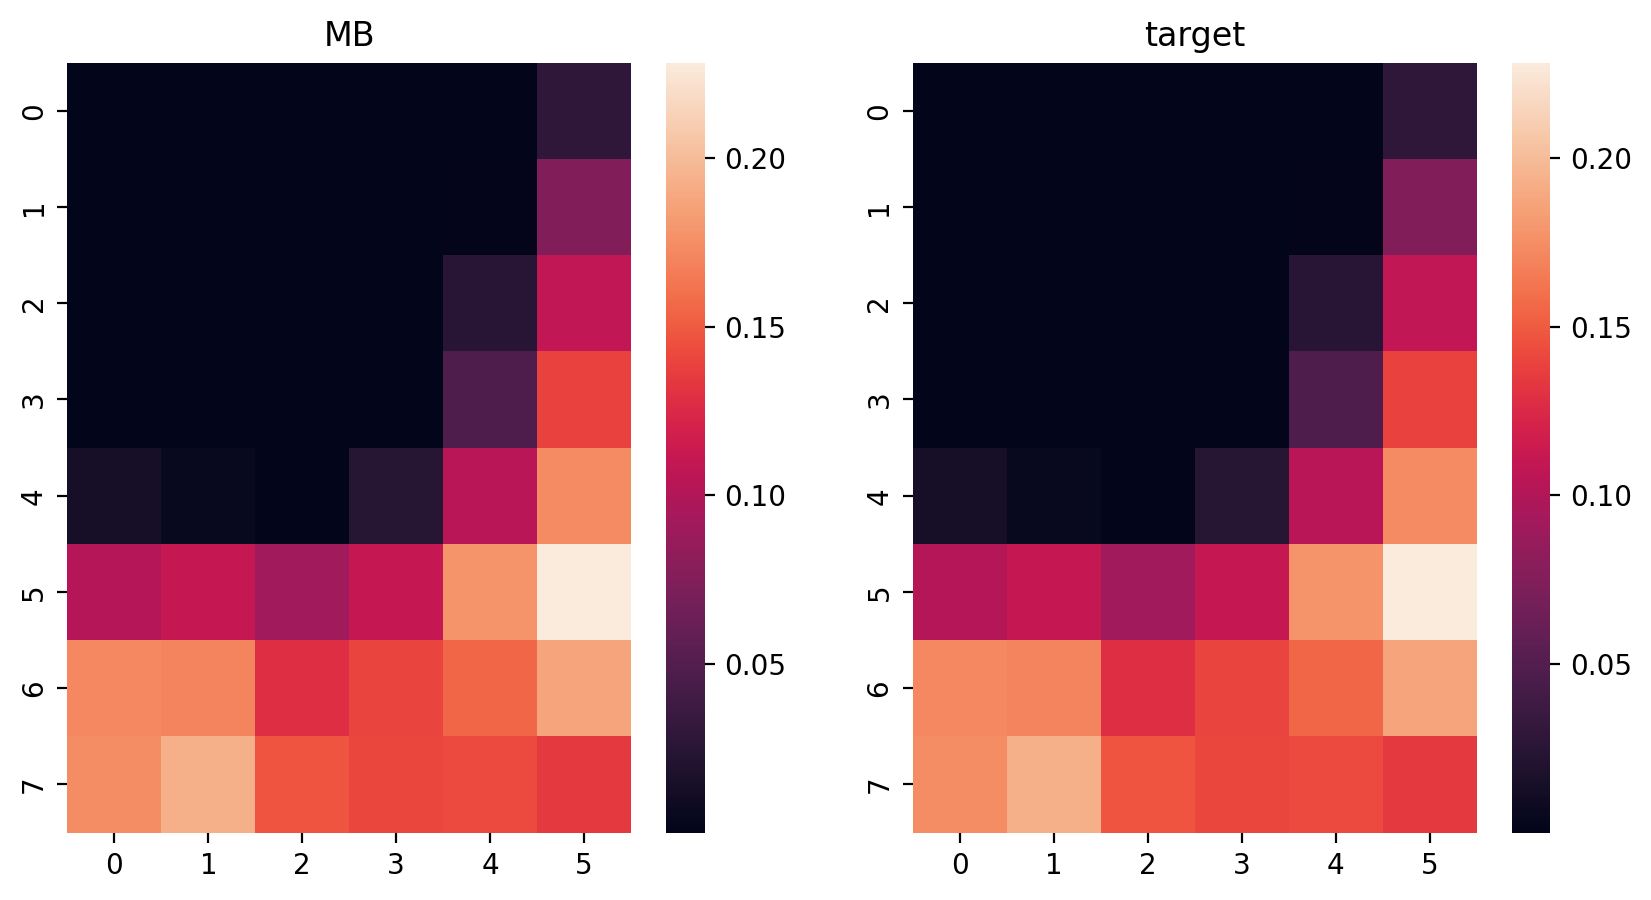

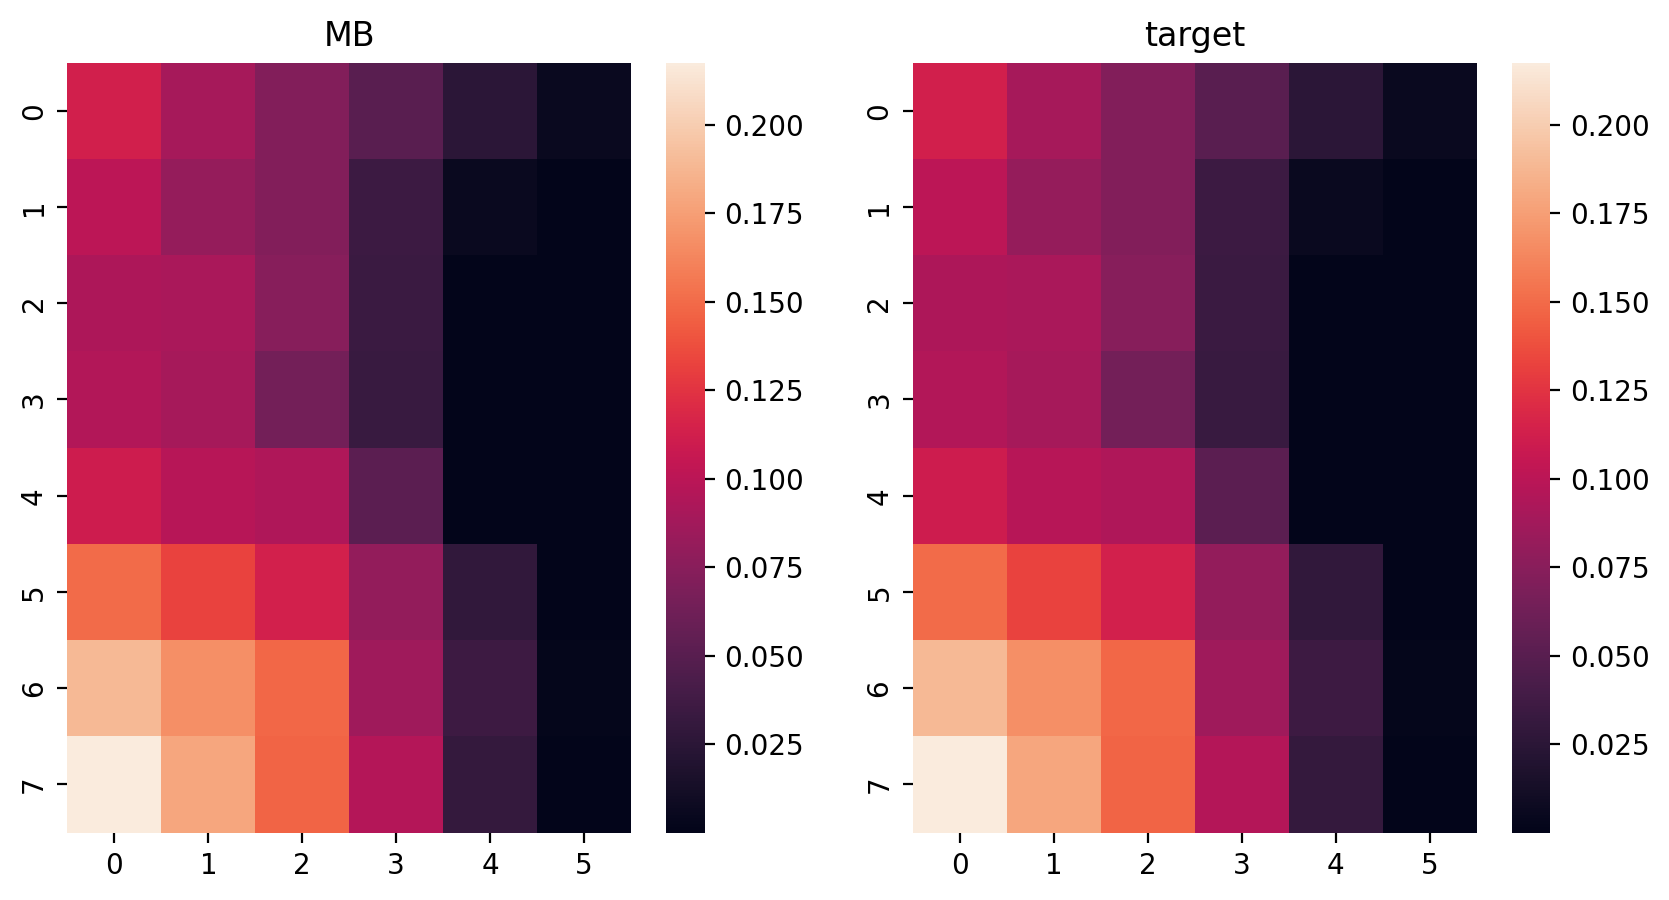

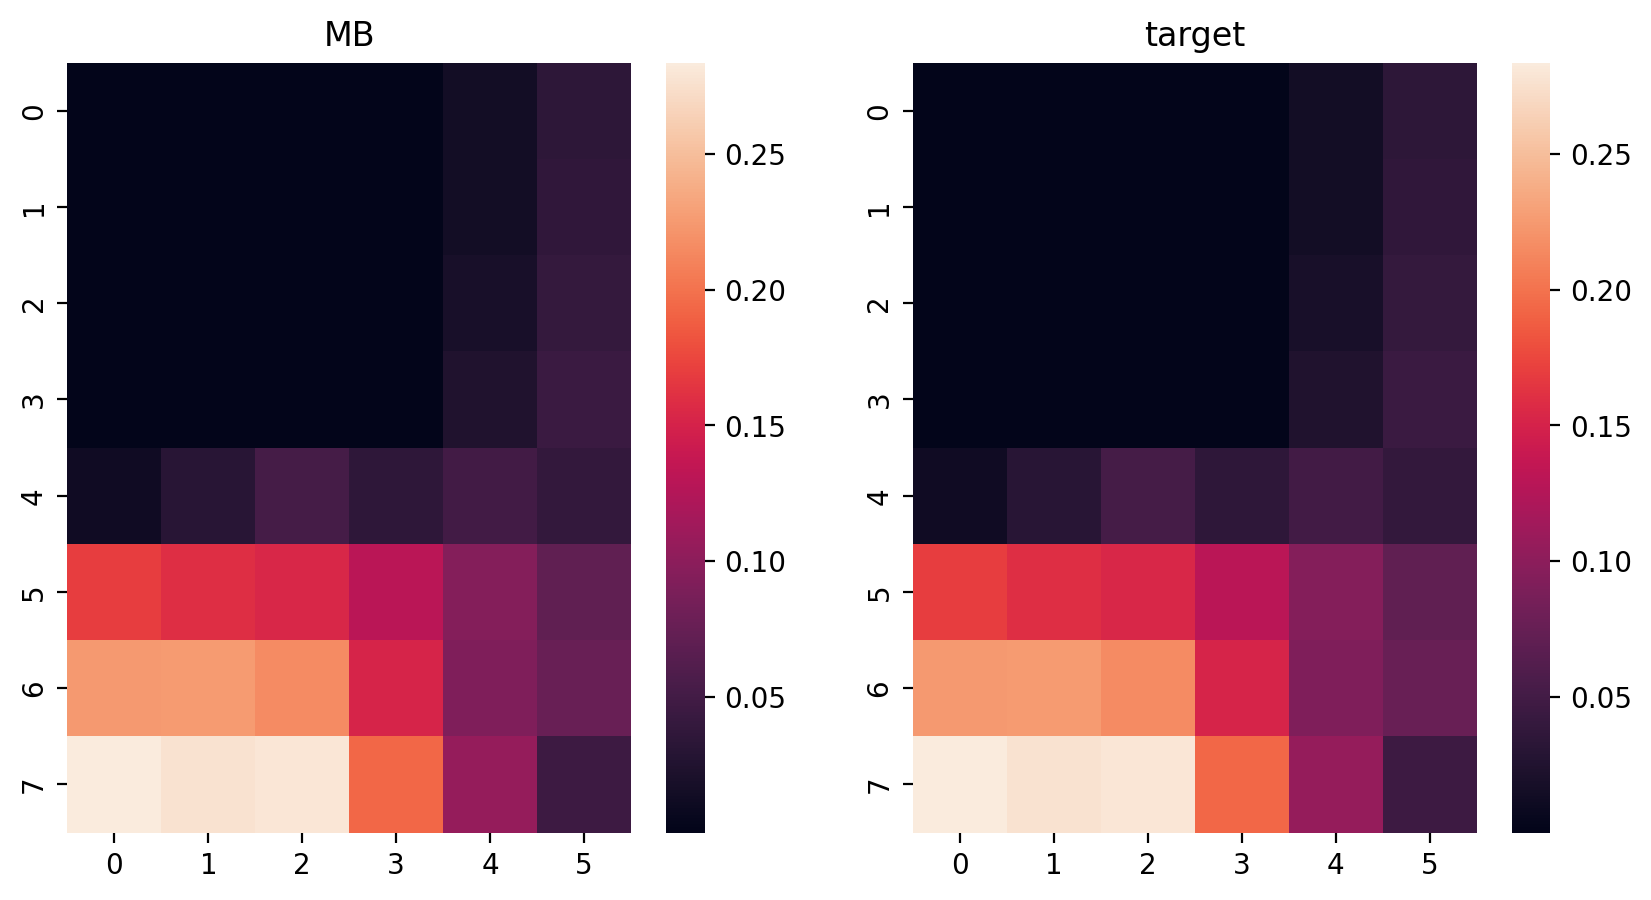

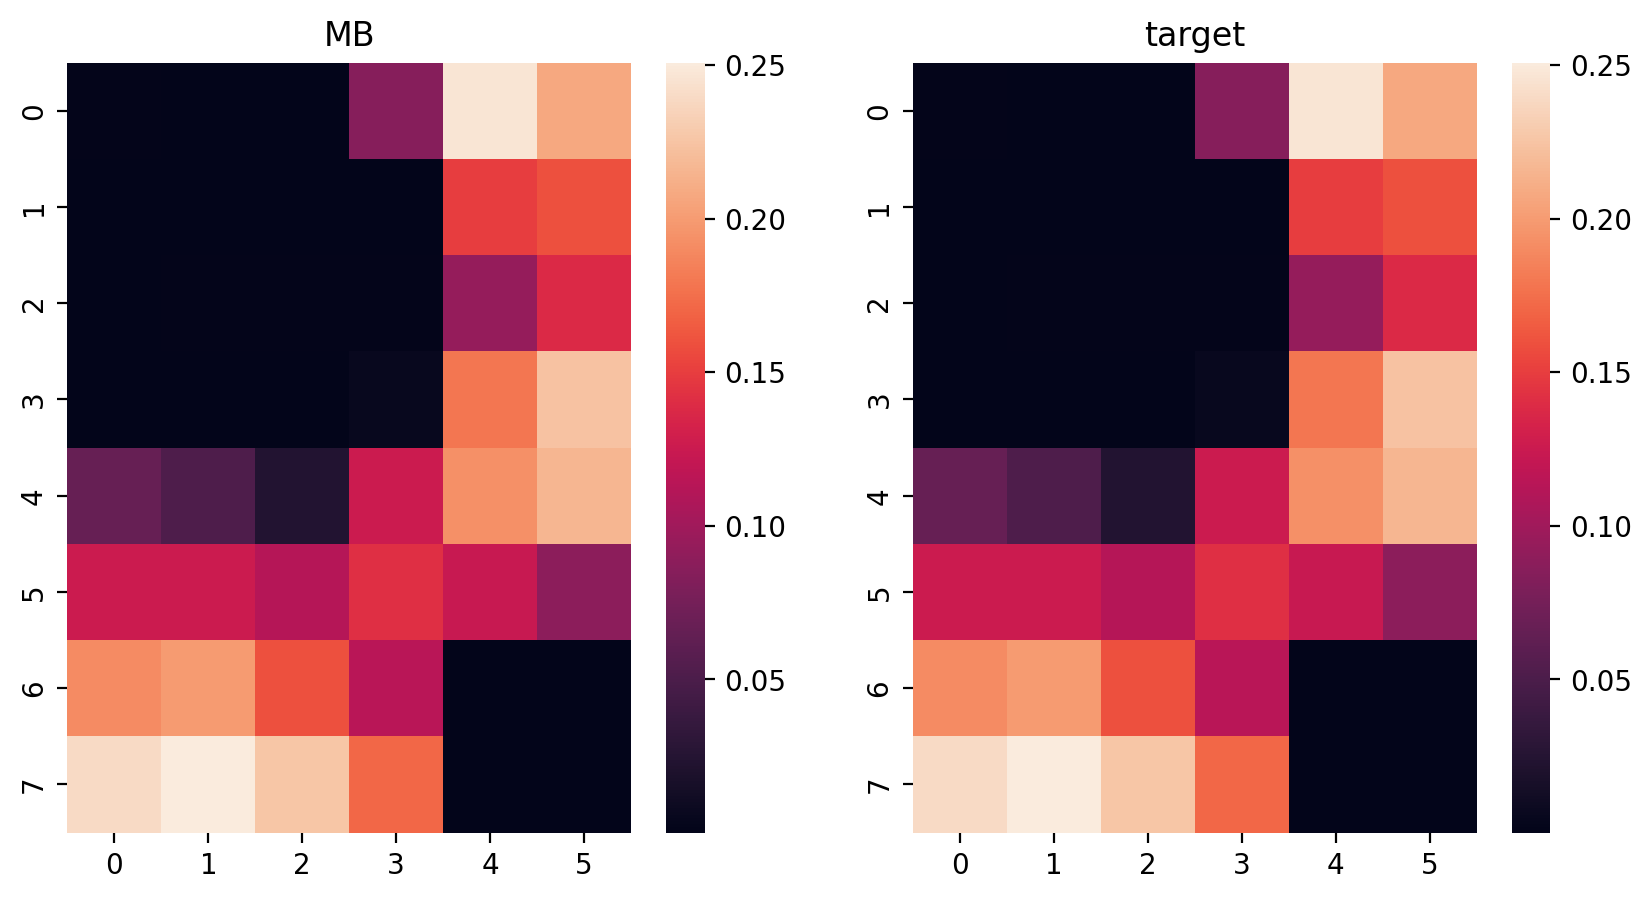

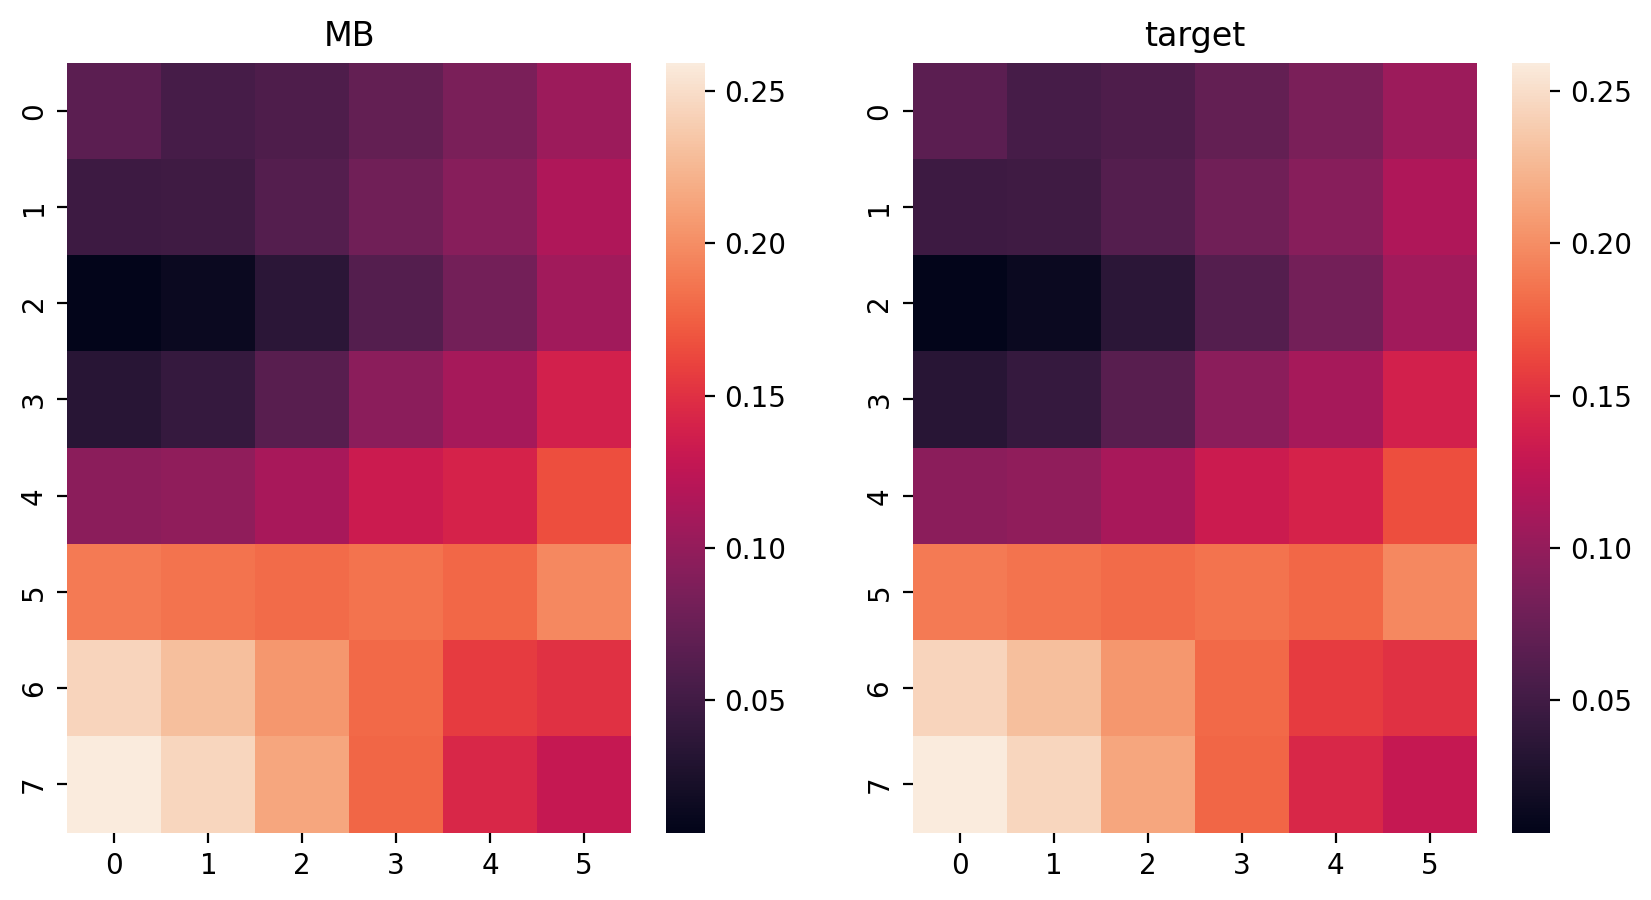

In [31]:
# Check readout mask transfer went successfully
for i in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.heatmap(mb_model.readout["session_1_ventral1_20200226_mb"].masks[:, :, i].detach().cpu().numpy(), ax=ax[0])
    sns.heatmap(ct_model.readout["session_1_ventral1_20200226"].masks[:, :, i].detach().cpu().numpy(), ax=ax[1])
    ax[0].set_title("MB")
    ax[1].set_title("target")
    plt.show()

In [32]:
(
    inputs,
    metadata,
    numerical_metadata,
    targets,
) = sample_batch
ct_model.cpu()
with torch.no_grad():
    test_output = ct_model(inputs, metadata, numerical_metadata, data_key="session_1_ventral1_20200226")

In [33]:
test_output.shape

torch.Size([64, 20, 131])

In [34]:
trainer_config = {
    "max_iter": 500,
    "scale_loss": True,
    "lr_decay_steps": 4,
    "tolerance": 0.0005,
    "patience": 8,
    "verbose": True,
    "lr_init": 0.004,
    "avg_loss": False,
    "loss_function": "PoissonLoss3d",
    "stop_function": "corr_stop3d",
    "loss_accum_batch_n": 1,
    "parallel": True,
    "clip_gradient_norm": True,
    "objective_function": metadata_model_full_objective,
}

In [35]:
import warnings

warnings.simplefilter("error", RuntimeWarning)

test_score, val_score, output, model_state = trainer(
    model=ct_model,
    dataloaders=dataloaders,
    seed=1000,
    **trainer_config,
)

Random seed 1000 has been set.


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

val_correlation -0.02114891519732835
val_poisson_loss 2.2371852405287296
val_MSE_loss 3.656561602638233


Epoch 1:   0%|          | 0/268 [00:00<?, ?it/s]

val_correlation 0.0629685837323014
val_poisson_loss 1.5012233058075795
val_MSE_loss 2.4578543255816045


Epoch 2:   0%|          | 0/268 [00:00<?, ?it/s]

val_correlation 0.09041233772382805
val_poisson_loss 1.5252903406949263
val_MSE_loss 2.65678186385882


Epoch 3:   0%|          | 0/268 [00:00<?, ?it/s]

val_correlation 0.10638027826095983
val_poisson_loss 1.3895876675262973
val_MSE_loss 1.907747612649341


Epoch 4:   0%|          | 0/268 [00:00<?, ?it/s]

val_correlation 0.1290217875282106
val_poisson_loss 1.385656065505925
val_MSE_loss 1.8950443586388925


Epoch 5:   0%|          | 0/268 [00:00<?, ?it/s]

val_correlation 0.1449751208093229
val_poisson_loss 1.402288120303516
val_MSE_loss 1.9892208975501389


Epoch 6:   0%|          | 0/268 [00:00<?, ?it/s]

val_correlation 0.16161745491789511
val_poisson_loss 1.3753529649622969
val_MSE_loss 1.8302634857985691


Epoch 7:   0%|          | 0/268 [00:00<?, ?it/s]

val_correlation 0.14139321783367315
val_poisson_loss 1.3590307447512648
val_MSE_loss 1.7856191562503658


Epoch 8:   0%|          | 0/268 [00:00<?, ?it/s]

val_correlation 0.15398110065935647
val_poisson_loss 1.3583052539835274
val_MSE_loss 1.7871303363844975


Epoch 9:   0%|          | 0/268 [00:00<?, ?it/s]

val_correlation 0.16414322984077603
val_poisson_loss 1.354692958991202
val_MSE_loss 1.7673292838975676


Epoch 10:   0%|          | 0/268 [00:00<?, ?it/s]

val_correlation 0.15141175706832596
val_poisson_loss 1.3526929828077472
val_MSE_loss 1.7617657329085117


Epoch 11:   0%|          | 0/268 [00:00<?, ?it/s]

val_correlation 0.1623815764274728
val_poisson_loss 1.368770023670857
val_MSE_loss 1.8359366613909183


Epoch 12:   0%|          | 0/268 [00:00<?, ?it/s]

val_correlation 0.16052785375168893
val_poisson_loss 1.3588889078500073
val_MSE_loss 1.785240568916195


Epoch 13:   0%|          | 0/268 [00:00<?, ?it/s]

val_correlation 0.1589376982820257
val_poisson_loss 1.3588557255745526
val_MSE_loss 1.791127181078128


Epoch 14:   0%|          | 0/268 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
test_score

0.3854985126144601

In [ ]:
val_score

0.17848819099308863

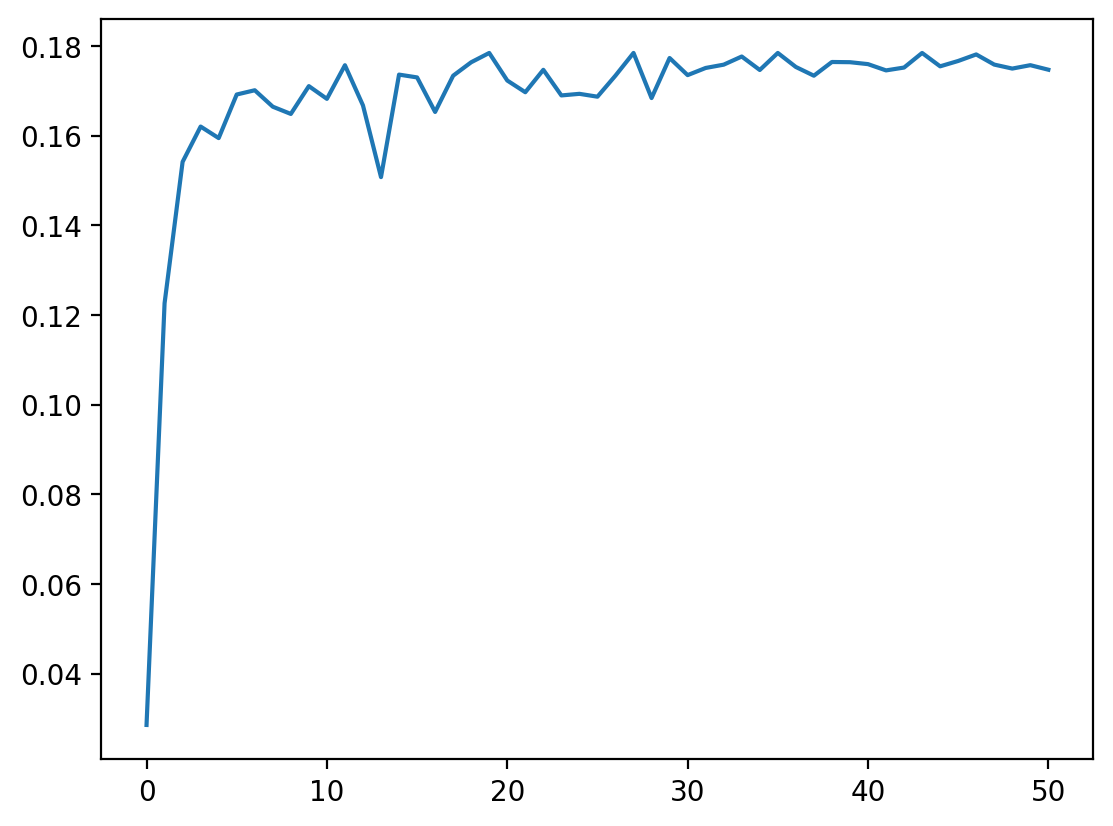

In [ ]:
plt.plot(output["val_correlation"])

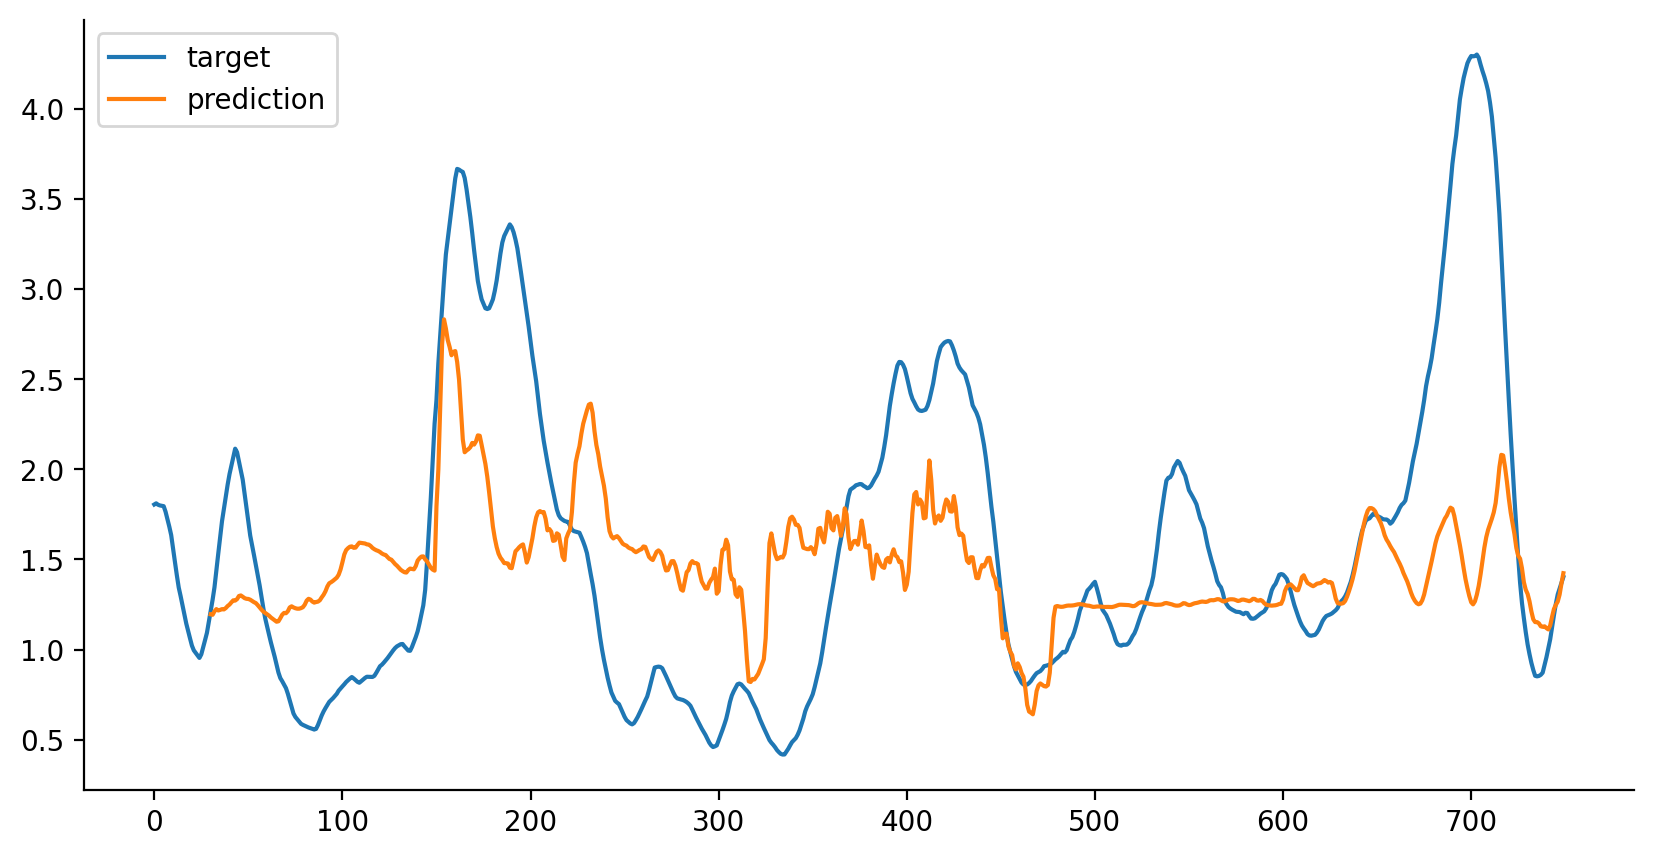

In [ ]:
# Plot an example reconstruction
example_field = next(iter(dataloaders["test"]))
test_sample = next(iter(dataloaders["test"][example_field]))

inputs, targets = test_sample[:-1], test_sample[-1]

ct_model.eval()
ct_model.cpu()

with torch.no_grad():
    reconstructions, feature_weights = ct_model(
        *[tensors_to_device(input, "cpu") for input in inputs], example_field, return_features=True
    )
reconstructions = reconstructions.cpu().numpy().squeeze()

targets = targets.cpu().numpy().squeeze()
window = 750
neuron = 0

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(np.arange(0, window), targets[:window, neuron], label="target")
ax.plot(np.arange(30, window), reconstructions[:window, neuron], label="prediction")
ax.legend()
sns.despine()

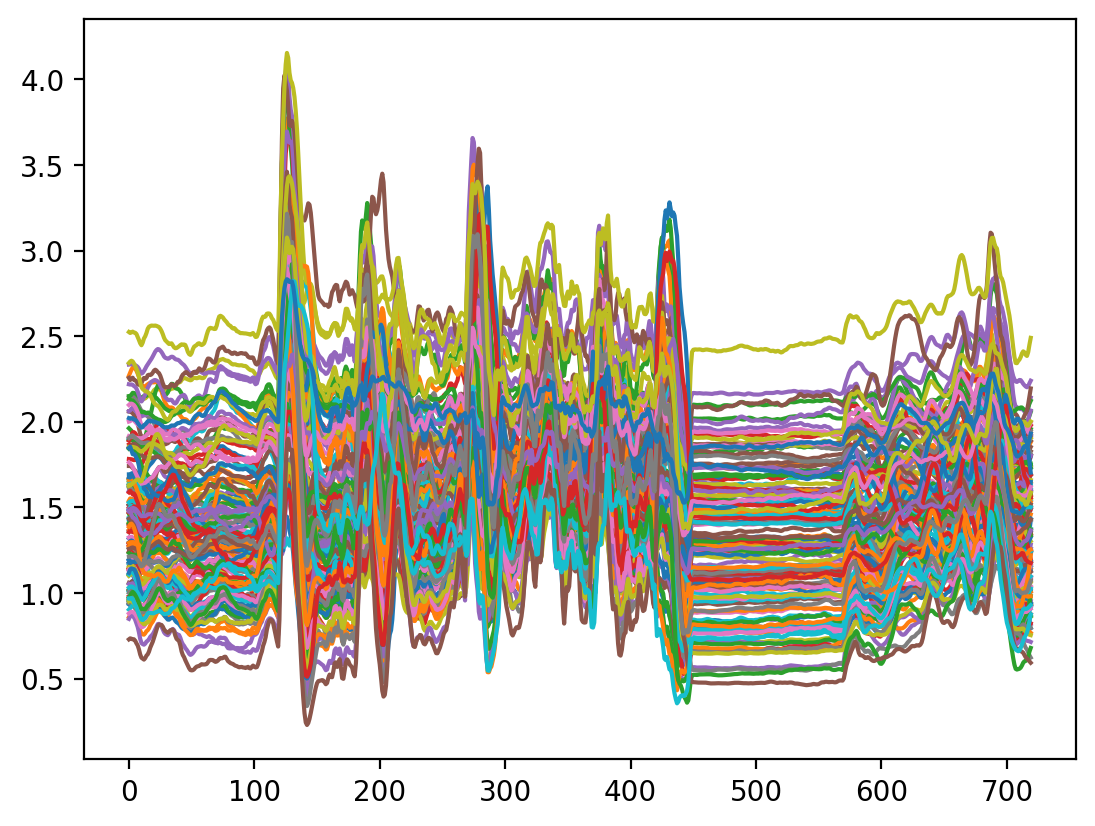

In [ ]:
plt.plot(reconstructions)

In [ ]:
np.allclose(reconstructions[:, 0], reconstructions[:, 1], atol=0.1)

False

In [ ]:
torch.allclose(feature_weights[:, 1], feature_weights[:, 0], atol=0.0001)

False